# Palette search
Our previous search techniques involve comparison (in some way) of all of the pixels in an image. This final search technique depends only on the palette of an image, ie 5 colours, or 15 values. The reduced dimensionality of the search space both allows for significant improvements to the speed of the search while also necessitating a slightly more complex algorithm by which to search.  
The process is roughly as follows:
1. generate palettes for all images using the technique described in notebook 01
2. for each unique pair of palettes
  - reorder the first palette to most closely align with the colours of the second
  - for each close colour pair, calculate their euclidian distance in CIELAB space
  - take the sum of the colour distances as the overall distance between the images
  
We have already established a method to generate palettes. The first thing we need to do here is solve problem 2.1 above: the linear assignment problem between palettes

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
plt.rcParams['figure.figsize'] = (20, 20)

import os
import itertools
import numpy as np
import pandas as pd
from PIL import Image

from sklearn.cluster import KMeans
from skimage.color import rgb2lab, lab2rgb
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cosine
from scipy.spatial.distance import pdist, squareform

from tqdm import tqdm_notebook as tqdm

### The assignment problem
When we compare a palette to itself we should naturally produce a _palette distance_ score of 0 (the colours are identical so we should measure no difference between them). However, when the first version of the palette is shuffled and the palettes are compared piecewise (eg fig 1, left), a significant difference would be measured!  
If we compare two randomly selected palettes, there's a good chance that similar colours within the palettes would also go unrecognised, and very similar colour combinations would be measured as wildly different. This matters less in the case of the uniformly neutral/beige/grey tone images where contrast is low, but as contrast differences increase and new bright colours are introduced, the matching problem becomes significant.

To overcome this, we need find a way of un-shuffling the first palette and pairing up the matched colours. We also need this process to work where colours are not exactly matched, but close enough to reduce the overall similarity score.  
The solution involves us treating each palette as one side of a bipartite graph, and finding the [minimum bijection](https://en.wikipedia.org/wiki/Bijection) between them. This could be solved by a number of approaches, but here we'll use the [Hungarian algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm), as implemented in `scipy`'s `linear_sum_assignment()` function. In the simplest terms, the algorithm draws links between all colour combinations and searches for the complete matching of minimal cost within those $n^{2}$ options (fig 1, right). Note that we return the combination of _minimum_ cost, not 0 cost - this process works for even the most mismatched palettes as long as the colour distance is well defined. 

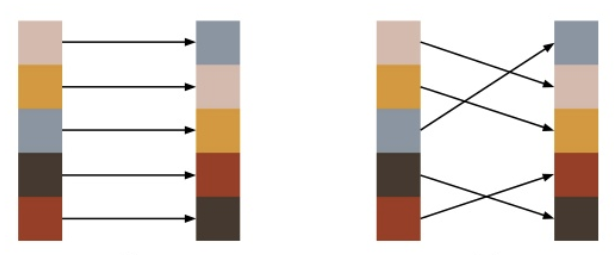
Thanks to Etienne Ferrier and his [masters thesis](https://www.slideshare.net/slideshow/embed_code/key/K4j44642NfjNLS) for the image above.

Lets load up some images and extract their palettes as we did in notebook 01.

In [ ]:
path_to_images = '../data/small_images/'
image_1 = Image.open(path_to_images + np.random.choice(os.listdir(path_to_images)))
image_2 = Image.open(path_to_images + np.random.choice(os.listdir(path_to_images)))

In [ ]:
image_1

In [ ]:
image_2

In [ ]:
def get_palette(image, palette_size=5, image_size=75):
    '''
    Return n dominant colours for a given image
    
    Parameters
    ----------
    image : PIL.Image
        The image for which we want to create a palette of dominant colours
    palette_size : 
        The number of dominant colours to extract
    image_size : 
        Images are resized and squared by default to reduce processing time.
        This value sets the side-length of the square. Higher values will 
        indrease fidelity,  
    
    Returns
    -------
    palette : np.array
        palette coordinates in LAB space
    '''
    image = image.resize((image_size, image_size))
    lab_image = rgb2lab(np.array(image)).reshape(-1, 3)
    clusters = KMeans(n_clusters=palette_size).fit(lab_image)
    return clusters.cluster_centers_


def display_palette(palette_colours, image_size=100, big=False):
    '''
    Return n dominant colours for a given image
    
    Parameters
    ----------
    palette_colours : np.array
        palette coordinates in LAB space
    image_size : 
        The size of each palette colour swatch to be returned
    
    Returns
    -------
    palette : PIL.Image
        image of square colour swatches
    '''
    palette_size=len(palette_colours)
    
    scale = 1
    if big: scale = 5
    
    stretched_colours = [(lab2rgb(np.array(colour.tolist() * image_size * image_size * scale)
                                  .reshape(image_size * scale, image_size, 3)) * 255)
                         .astype(np.uint8) 
                         for colour in palette_colours]
    
    palette_array = (np.hstack(stretched_colours)
                     .reshape((image_size * scale, 
                               image_size * palette_size, 
                               3)))

    return Image.fromarray(palette_array)


def colour_distance(colour_1, colour_2):
    return sum([(a - b) ** 2 for a, b in zip(colour_1, colour_2)]) ** 0.5

In [ ]:
palette_1 = get_palette(image_1)
display_palette(palette_1)

In [ ]:
palette_2 = get_palette(image_2)
display_palette(palette_2)

### Finding the minimum bijection between palettes
We first need to calculate the distance matrix for all 25 colour combinations, which we'll store in a square matrix. It's worth noting that the distance is computed in LAB space, so should (roughly) match human perception of colour distances. The rearrangement of the first palette can then be computed using the `linear_sum_assignment()` of this distance matrix.

In [ ]:
distances = [[colour_distance(colour_1, colour_2)
              for colour_1 in palette_1] 
             for colour_2 in palette_2]

_, rearrangement = linear_sum_assignment(distances)
palette_1 = [palette_1[i] for i in rearrangement]

In [ ]:
display_palette(palette_1)

In [ ]:
display_palette(palette_2)

# Large scale palette similarity
Let's try applying this to a few more image combinations. We'll load in a random sample of images from the collection, generate their palettes, and pair them up to their corresponding image_ids in an `image_dict` and `palette_dict`

In [ ]:
n_images = 1000
path_to_images = '../data/small_images/'

random_ids = np.random.choice(os.listdir(path_to_images), 
                              n_images, 
                              replace=False)

image_dict = {}
palette_dict = {}

for image_id in tqdm(random_ids):
    try: 
        image = Image.open(path_to_images + image_id)
        
        if len(np.array(image).shape) != 3:
            image = Image.fromarray(np.stack((image,)*3, -1))
        
        image_dict[image_id] = image
        palette_dict[image_id] = get_palette(image)
    except: 
        pass
    
image_ids = np.sort(list(image_dict.keys()))

We've wrapped up the reordering process in the function below, with a final step to calculate the sum of the minimum bijection that is found. In the subsequent cell we're just churning through the combinations of palettes to produce the complete palette distance matrix.

In [ ]:
def palette_distance(palette_1, palette_2):
    distances = [[colour_distance(colour_1, colour_2)
                  for colour_1 in palette_1] 
                 for colour_2 in palette_2]

    _, rearrangement = linear_sum_assignment(distances)
    palette_1 = [palette_1[i] for i in rearrangement]

    palette_distance = sum([colour_distance(c_1, c_2) 
                            for c_1, c_2 in zip(palette_1, palette_2)])
    
    return palette_distance

In [ ]:
distances = {id_1: {id_2: palette_distance(palette_1, palette_2) 
              for id_2, palette_2 in palette_dict.items()} 
             for id_1, palette_1 in tqdm(palette_dict.items())}

palette_distances = pd.DataFrame(data=distances,
                                 index=image_ids,
                                 columns=image_ids)

In [ ]:
sns.heatmap(palette_distances);

We can now grab a sorted column/row from the matrix to give us the most indexes of the most similar images to a query id! Here's a query palette with its closest match

In [ ]:
query_id = np.random.choice(image_ids[:100])
most_similar_palette = palette_distances[query_id].sort_values().index.values[1]
print(query_id, most_similar_palette)

In [ ]:
display_palette(get_palette(Image.open('../data/small_images/' + query_id)))

In [ ]:
display_palette(get_palette(Image.open('../data/small_images/' + most_similar_palette)))

# Palette-based search
We can also return the images that appear to be most similar to the query. Here's a randomly chosen query image.

In [ ]:
query_id = np.random.choice(image_ids)
Image.open(path_to_images + query_id)

Here's the palette we detected for it

In [ ]:
display_palette(palette_dict[query_id])

and here are the top n images with similar palettes

In [ ]:
res = 200
n_similar = 16
size = int(n_similar ** 0.5)

big_image = np.empty((int(res * size), int(res * size), 3)).astype(np.uint8)
grid = np.array(list(itertools.product(range(size), range(size))))

most_similar_ids = palette_distances[query_id].sort_values().index.values[1 : n_similar+1]
similar_images = [image_dict[image_id].resize((res, res), resample=Image.LANCZOS) 
                  for image_id in most_similar_ids]

for pos, image in zip(grid, similar_images):
    block_t, block_l = pos * res
    block_b, block_r = (pos + 1) * res
    
    big_image[block_t : block_b, block_l : block_r] = np.array(image)

Image.fromarray(big_image)

In [ ]:
print('https://wellcomecollection.org/works?query=' + 
      '+'.join([id.strip('.jpg') for id in most_similar_ids]))

I think this process produces the nicest set of results by quite a long way (though as always, it's hard to know whether my own perception is universal). The fact that we're only comparing the dominant or distinct colours in the image, without weight or bias between them, means that the features picked out by human eyes seem well matched by the machine.